In [1]:
import matplotlib.pylab as plt
import os

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.dominating import dominating_set

from dwave.system.samplers import DWaveSampler
from minorminer import find_embedding
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite
from dimod.utilities import qubo_to_ising
from dwave.embedding import embed_qubo

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import (
    QUBO_to_Ising,
    retry_embedding,
    find_offset,
    AnnealOffset,
    plot_anneal_offset,
)

In [2]:
nvertices = 10

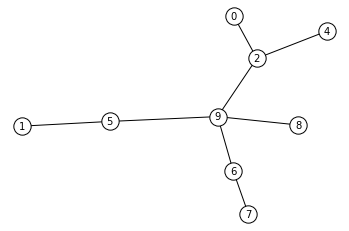

IndexError: column index (9) out of range

In [4]:
#graph, tag = gt.generate_nn_graph(nvertices)
#graph, tag = gt.generate_corona_graph(2, 0)

graph, tag = gt.generate_erdos_renyi_graph(nvertices, np.log(nvertices)/nvertices)
# plot graph
gt.get_plot(graph, directed=False)
plt.show()

penalty = 2
qubo = get_mds_qubo(
    graph, directed=False, penalty=penalty, triangularize=True, dtype="d"
)


q_min = np.array(list(qubo.values())).min()

# greedy solution
G = nx.Graph()
G.add_edges_from(graph)
print("Greedy solution\n", dominating_set(G))

In [ ]:
# Embedding retries
retries = 100000
# Set functional form of anneal offset
target_min = -0.08
target_range = 0.11
problem_min = 0
#problem_range = 2*abs(pmin)
problem_range = abs(problem_min)
# DWave parameters
annealing_time = 800  # integer microseconds [1, 2000] #OPTIMIZED
answer_mode = "histogram"  # histogram or raw
auto_scale = True
num_reads = 1000  # raw will dump out all results
num_spin_reversal_transforms = 0 # OPTIMIZED
readout_thermalization = 0  # default 0
programming_thermalization = 1000  # default 1000

solver = "Advantage_system1.1"
sampler = DWaveSampler(solver=solver)

In [ ]:
# convert to Ising
J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
# Set chain strength
chain_strength = maxJ * 2

qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
qpu_graph = sampler.edgelist
embed, embedding, min_offset, max_offset = retry_embedding(
    sampler=sampler,
    qubo_dict=qubo_dict,
    qpu_graph=qpu_graph,
    graph_tag=tag,
    target_min=target_min,
    target_range=target_range,
    n_tries=retries,
)

dwave_config = {
    "annealing_time": annealing_time,  # integer microseconds [1, 2000]
    "answer_mode": answer_mode,  # histogram or raw
    "auto_scale": auto_scale,
    "num_reads": num_reads,  # raw will dump out all results
    "num_spin_reversal_transforms": num_spin_reversal_transforms,
    "readout_thermalization": readout_thermalization,  # default 0
    "programming_thermalization": programming_thermalization,  # default 1000
    "chain_strength": chain_strength,
}

result = embed.sample_qubo(qubo_dict, **dwave_config)
raw = result.to_pandas_dataframe()

In [ ]:
raw.sort_values("energy", ascending=True)